# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 


In [49]:
import pandas as pd
import numpy as np
from scapy.all import rdpcap, IP, TCP, UDP, DNS

data = rdpcap("../notebooks/data/netflix.pcap")

In [15]:
rows = []
for p in data:
    if IP in p:
        proto = "TCP" if TCP in p else ("UDP" if UDP in p else None)
        sport = p[TCP].sport if TCP in p else (p[UDP].sport if UDP in p else None)
        dport = p[TCP].dport if TCP in p else (p[UDP].dport if UDP in p else None)
        
        rows.append({
            "timestamp": p.time,
            "src_ip": p[IP].src,
            "dst_ip": p[IP].dst,
            "protocol": proto,
            "src_port": sport,
            "dst_port": dport,
            "length": len(p),
            "has_dns": DNS in p
        }) 

df = pd.DataFrame(rows)
df.head()

,timestamp,src_ip,dst_ip,protocol,src_port,dst_port,length,has_dns
0,1518358200.534682,192.168.43.72,128.93.77.234,UDP,55697.0,53.0,77,True
1,1518358200.534832,192.168.43.72,128.93.77.234,UDP,59884.0,53.0,77,True
2,1518358200.539408,192.168.43.72,128.93.77.234,UDP,61223.0,53.0,87,True
3,1518358200.541204,192.168.43.72,128.93.77.234,UDP,58785.0,53.0,87,True
4,1518358200.545785,192.168.43.72,128.93.77.234,UDP,51938.0,53.0,78,True


In [11]:
print(df.head())

           timestamp         src_ip         dst_ip protocol  src_port  \
0  1518358200.534682  192.168.43.72  128.93.77.234      UDP   55697.0   
1  1518358200.534832  192.168.43.72  128.93.77.234      UDP   59884.0   
2  1518358200.539408  192.168.43.72  128.93.77.234      UDP   61223.0   
3  1518358200.541204  192.168.43.72  128.93.77.234      UDP   58785.0   
4  1518358200.545785  192.168.43.72  128.93.77.234      UDP   51938.0   

   dst_port  length  has_dns  
0      53.0      77     True  
1      53.0      77     True  
2      53.0      87     True  
3      53.0      87     True  
4      53.0      78     True  


### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [42]:
NETFLIX_DOMAINS = {"netflix.com", "netflix.net", "nflxvideo.net", "nflxso.net", "nflximg.net", "nflxext.com", "nflximg.com"}

def is_netflix(domain):
    domain = domain.lower().strip(".")
    return any(domain.endswith(suffix) for suffix in NETFLIX_DOMAINS)

def safe_decode(value):
    if isinstance(value, (bytes, bytearray)):
        return value.decode('utf-8', errors='ignore')
    return str(value)

netflix_domains = set()
netflix_ips = set()
ip_domain_map = {}

for packet in data:
    if DNS not in packet:
        continue
    
    dns = packet[DNS]

    if dns.qd:
        queries = dns.qd if isinstance(dns.qd, list) else [dns.qd]
        for query in queries:
            qname = safe_decode(getattr(query, 'qname', '')).lower().rstrip(".")
            if qname and is_netflix(qname):
                netflix_domains.add(qname)
    
    if dns.an:
        answers = dns.an if isinstance(dns.an, list) else [dns.an]
        for answer in answers:
            rrname = safe_decode(getattr(answer, 'rrname', '')).lower().rstrip(".")
            if rrname and is_netflix(rrname):
                # Only A (1) and AAAA (28) records have IP addresses
                rr_type = getattr(answer, 'type', None)
                if rr_type in (1, 28):
                    ip = safe_decode(getattr(answer, 'rdata', ''))
                    if ip:
                        netflix_ips.add(ip)
                        ip_domain_map[ip] = rrname

netflix_df = df[(df['dst_ip'].isin(netflix_ips)) | (df['src_ip'].isin(netflix_ips))]

In [43]:
len(netflix_df)

138633

### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [67]:
netflix_df['direction'] = netflix_df['src_ip'].str.startswith('192.168').map({True: 'upstream', False: 'downstream'})
netflix_df = netflix_df.sort_values('timestamp')
netflix_df['iat'] = netflix_df['timestamp'].diff().astype(float)

for c in ["src_port", "dst_port"]:
    netflix_df[c] = pd.to_numeric(netflix_df[c], errors="coerce").astype("Int64")

def port_str(s):
    return s.astype("Int64").astype("string").fillna("NA")

netflix_df["flow_id"] = (
    netflix_df["src_ip"].astype("string") + ":" + port_str(netflix_df["src_port"]) + "→" +
    netflix_df["dst_ip"].astype("string") + ":" + port_str(netflix_df["dst_port"])
)

flow_groups = netflix_df.groupby('flow_id')

features = []
for flow_id, flow_df in flow_groups:
    downstream = flow_df[flow_df['direction'] == 'downstream']
    upstream = flow_df[flow_df['direction'] == 'upstream']
    duration = flow_df['timestamp'].max() - flow_df['timestamp'].min()
    
    feature_dict = {
        'flow_id': str(flow_id),
        'pkt_count': len(flow_df),
        'byte_total': flow_df['length'].sum(),
        'byte_mean': flow_df['length'].mean(),
        'byte_std': flow_df['length'].std(),
        'flow_duration': duration,
        'iat_mean': flow_df['iat'].mean(),
        'iat_std': flow_df['iat'].std(),
        'flow_center_ts': flow_df['timestamp'].mean(),
        'downstream_packets': len(downstream),
        'downstream_bytes': downstream['length'].sum(),
        'upstream_packets': len(upstream),
        'upstream_bytes': upstream['length'].sum(),
        'pkt_size_min': flow_df['length'].min(),
        'pkt_size_max': flow_df['length'].max(),
        'iat_min': flow_df['iat'].min(),
        'iat_max': flow_df['iat'].max(),
        'avg_throughput_bps': (flow_df['length'].sum() * 8) / duration if duration > 0 else 0,
    }
    features.append(feature_dict)

features_df = pd.DataFrame(features)
features_df.head()

,flow_id,pkt_count,byte_total,byte_mean,byte_std,flow_duration,iat_mean,iat_std,flow_center_ts,downstream_packets,downstream_bytes,upstream_packets,upstream_bytes,pkt_size_min,pkt_size_max,iat_min,iat_max,avg_throughput_bps
0,192.168.43.72:58451→198.38.120.130:443,12,1064,88.666667,50.281631,14.440177,0.000224,0.000504,1.518358e+09,0,0,12,1064,66,200,0.000035,0.001739,589.4664587560110932158241551
1,192.168.43.72:58452→198.38.120.130:443,11,998,90.727273,52.201707,14.442865,0.000286,0.000615,1.518358e+09,0,0,11,998,66,200,0.000046,0.002137,552.7989079728987288879318612
2,192.168.43.72:58453→198.38.120.130:443,12,1064,88.666667,50.281631,14.437420,0.009680,0.032620,1.518358e+09,0,0,12,1064,66,200,0.000044,0.113249,589.5790245071487842010553132
3,192.168.43.72:58454→52.19.39.146:443,208,25627,123.206731,66.604250,138.854511,0.021376,0.115984,1.518358e+09,0,0,208,25627,54,200,0.000000,1.010533,1476.480659674067052816166700
4,192.168.43.72:58455→52.19.39.146:443,27,3382,125.259259,67.614628,74.817607,0.000959,0.002972,1.518358e+09,0,0,27,3382,54,200,0.000000,0.014731,361.6261076086007401974243843


**Write a brief justification for the features that you have chosen.**

`flow_id`: Unique identifier for each network flow (5-tuple: src_ip, dst_ip, src_port, dst_port, protocol)

`pkt_count`: Total packets in flow, indicates session length - more packets = longer streaming session

`byte_total, byte_mean, byte_std`: Total bytes, mean packet size, and variance. Larger packets and low variance indicate high-quality, consistent video delivery

`flow_duration`: Time between first and last packet. longer duration = sustained streaming session

`iat_mean, iat_std`: Mean and variance of time between packets, since low variance means smooth playback and high variance indicates buffering

`flow_center_ts`: Mean timestamp of flow captures time-of-day effects on network conditions

`downstream/upstream packets/bytes`: Measures directional 

`pkt_size_min/max, iat_min/max`: Extreme values that capture anomalies like quality switches or buffering events

`avg_throughput_bps`: Bytes per second is a direct indicator of video quality

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [68]:
BIN_SEC = 2.0
ROLL_WINDOW_SEC = 30.0
ROLL_BINS = max(1, int(round(ROLL_WINDOW_SEC / BIN_SEC)))
FALLBACK_MIN = 10 * 1024

df = netflix_df.copy()
df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce").astype(float)
df["length"] = pd.to_numeric(df["length"], errors="coerce").astype(int)

# Create flow_id matching format
for c in ["src_port", "dst_port"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")

def port_str(s):
    return s.astype("Int64").astype("string").fillna("NA")

df["temp_flow_id"] = (
    df["src_ip"].astype("string") + ":" + port_str(df["src_port"]) + "→" +
    df["dst_ip"].astype("string") + ":" + port_str(df["dst_port"])
)

# Bin time
t0 = df["timestamp"].min()
df["bin"] = ((df["timestamp"] - t0) // BIN_SEC).astype(int)

# Bytes per (flow, bin)
bpb = (df.groupby(["temp_flow_id", "bin"], as_index=False)["length"]
       .sum()
       .rename(columns={"length": "bin_bytes"}))

if not bpb.empty:
    # Adaptive per-flow threshold
    stats = (bpb.groupby("temp_flow_id")["bin_bytes"]
             .agg(q75=lambda s: s.quantile(0.75),
                  q90=lambda s: s.quantile(0.90),
                  vmax="max")
             .reset_index())
    
    stats["thr"] = np.maximum(stats[["q90", "q75"]].max(axis=1), FALLBACK_MIN)
    stats["thr"] = np.minimum(stats["thr"], stats["vmax"]).astype(float)
    
    bpb = bpb.merge(stats[["temp_flow_id", "thr", "vmax"]], on="temp_flow_id", how="left")
    
    # Mark segments
    bpb["is_segment"] = ((bpb["bin_bytes"] >= bpb["thr"]) |
                         (bpb["bin_bytes"] >= 0.20 * bpb["vmax"])).astype(int)
    
    # Rolling segment rate
    def calc_rate(gr):
        gr = gr.sort_values("bin").copy()
        gr["segment_rate"] = gr["is_segment"].rolling(ROLL_BINS, min_periods=1).sum() / ROLL_WINDOW_SEC
        return gr
    
    rate_ts = bpb.groupby("temp_flow_id", group_keys=False).apply(calc_rate)
    
    segment_features = (rate_ts.groupby("temp_flow_id", as_index=False)
                        .agg(segment_rate_mean=("segment_rate", "mean"),
                             segment_rate_max=("segment_rate", "max"),
                             segment_burst_fraction=("is_segment", "mean")))
    
    segment_features.rename(columns={"temp_flow_id": "flow_id"}, inplace=True)
    
    #merge
    features_df = features_df.merge(segment_features, on="flow_id", how="left")
    features_df[["segment_rate_mean", "segment_rate_max", "segment_burst_fraction"]] = \
        features_df[["segment_rate_mean", "segment_rate_max", "segment_burst_fraction"]].fillna(0.0)
# else:
#     features_df["segment_rate_mean"] = 0.0
#     features_df["segment_rate_max"] = 0.0
#     features_df["segment_burst_fraction"] = 0.0

features_df.head()

,flow_id,pkt_count,byte_total,byte_mean,byte_std,flow_duration,iat_mean,iat_std,flow_center_ts,downstream_packets,...,upstream_packets,upstream_bytes,pkt_size_min,pkt_size_max,iat_min,iat_max,avg_throughput_bps,segment_rate_mean,segment_rate_max,segment_burst_fraction
0,192.168.43.72:58451→198.38.120.130:443,12,1064,88.666667,50.281631,14.440177,0.000224,0.000504,1.518358e+09,0,...,12,1064,66,200,0.000035,0.001739,589.4664587560110932158241551,0.058333,0.066667,0.500000
1,192.168.43.72:58452→198.38.120.130:443,11,998,90.727273,52.201707,14.442865,0.000286,0.000615,1.518358e+09,0,...,11,998,66,200,0.000046,0.002137,552.7989079728987288879318612,0.086667,0.133333,0.800000
2,192.168.43.72:58453→198.38.120.130:443,12,1064,88.666667,50.281631,14.437420,0.009680,0.032620,1.518358e+09,0,...,12,1064,66,200,0.000044,0.113249,589.5790245071487842010553132,0.058333,0.066667,0.500000
3,192.168.43.72:58454→52.19.39.146:443,208,25627,123.206731,66.604250,138.854511,0.021376,0.115984,1.518358e+09,0,...,208,25627,54,200,0.000000,1.010533,1476.480659674067052816166700,0.153333,0.266667,0.360000
4,192.168.43.72:58455→52.19.39.146:443,27,3382,125.259259,67.614628,74.817607,0.000959,0.002972,1.518358e+09,0,...,27,3382,54,200,0.000000,0.014731,361.6261076086007401974243843,0.118519,0.166667,0.555556


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [87]:
df = pd.read_pickle('netflix_dataset.pkl')
df.head()

,10_EWMA_chunksizes,10_avg_chunksize,10_chunksizes_50,10_chunksizes_50R,10_chunksizes_75,10_chunksizes_75R,10_chunksizes_85,10_chunksizes_85R,10_chunksizes_90,10_chunksizes_90R,...,userTwoRetransmit,userUrgFlags,userXRetransmit,userZeroRetransmit,service,startup3.3,startup6.6,startup5,startup10,startup_mc
208,"[[4380.0], [4380.0], [19682.095238095237], [23...",148947.1,43473.0,43473.0,185098.0,185098.0,361832.3,361832.3,461040.2,461040.2,...,0.0,0,0.108730,0.557937,netflix,False,False,False,False,12.0
209,"[[179260.0], [130204.0], [49666.09523809524], ...",91984.2,101882.0,101882.0,122323.0,122323.0,159843.4,159843.4,181011.8,181011.8,...,0.0,0,0.116865,0.549802,netflix,False,False,False,False,12.0
210,"[[317962.0], [83192.4], [170850.7619047619], [...",147725.0,111373.0,111373.0,224157.0,224157.0,286280.0,286280.0,325845.8,325845.8,...,0.0,0,0.126852,0.539815,netflix,False,False,False,False,12.0
211,"[[396800.0], [98961.6], [246910.09523809524], ...",246420.6,297522.0,297522.0,330737.5,330737.5,361030.7,361030.7,378404.0,378404.0,...,0.0,0,0.186111,0.480556,netflix,False,False,False,False,12.0
212,"[[325264.0], [331102.4], [365584.38095238095],...",336681.0,354461.0,354461.0,399719.5,399719.5,409866.3,409866.3,414060.0,414060.0,...,0.0,0,0.194444,0.472222,netflix,False,False,False,False,12.0


### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [88]:
valid = [240, 360, 480, 720, 1080]
df = df[df["resolution"].isin(valid)].copy()

df.head()

,10_EWMA_chunksizes,10_avg_chunksize,10_chunksizes_50,10_chunksizes_50R,10_chunksizes_75,10_chunksizes_75R,10_chunksizes_85,10_chunksizes_85R,10_chunksizes_90,10_chunksizes_90R,...,userTwoRetransmit,userUrgFlags,userXRetransmit,userZeroRetransmit,service,startup3.3,startup6.6,startup5,startup10,startup_mc
208,"[[4380.0], [4380.0], [19682.095238095237], [23...",148947.1,43473.0,43473.0,185098.0,185098.0,361832.3,361832.3,461040.2,461040.2,...,0.0,0,0.108730,0.557937,netflix,False,False,False,False,12.0
209,"[[179260.0], [130204.0], [49666.09523809524], ...",91984.2,101882.0,101882.0,122323.0,122323.0,159843.4,159843.4,181011.8,181011.8,...,0.0,0,0.116865,0.549802,netflix,False,False,False,False,12.0
210,"[[317962.0], [83192.4], [170850.7619047619], [...",147725.0,111373.0,111373.0,224157.0,224157.0,286280.0,286280.0,325845.8,325845.8,...,0.0,0,0.126852,0.539815,netflix,False,False,False,False,12.0
211,"[[396800.0], [98961.6], [246910.09523809524], ...",246420.6,297522.0,297522.0,330737.5,330737.5,361030.7,361030.7,378404.0,378404.0,...,0.0,0,0.186111,0.480556,netflix,False,False,False,False,12.0
212,"[[325264.0], [331102.4], [365584.38095238095],...",336681.0,354461.0,354461.0,399719.5,399719.5,409866.3,409866.3,414060.0,414060.0,...,0.0,0,0.194444,0.472222,netflix,False,False,False,False,12.0


2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [94]:
# lists and arrays
def identify_list_columns(df):
    list_cols = []
    for col in df.columns:
        if df[col].dtype == 'object':
            sample = df[col].dropna().iloc[0] if len(df[col].dropna()) > 0 else None
            if isinstance(sample, (list, tuple, dict, np.ndarray)):
                list_cols.append(col)
    return list_cols

# empty cols
def identify_mostly_missing(df, threshold=0.8):
    missing_rate = df.isnull().sum() / len(df)
    return missing_rate[missing_rate > threshold].index.tolist()

# low var
def identify_low_variance(df, threshold=0.01):
    low_var_cols = []
    for col in df.select_dtypes(include=[np.number]).columns:
        if df[col].var() < threshold:
            low_var_cols.append(col)
    return low_var_cols

# multicorr
def identify_highly_correlated(df, threshold=0.95):
    numeric_df = df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop

# duplicates
def identify_duplicate_columns(df):
    duplicates = []
    cols = df.columns.tolist()
    
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            if df[cols[i]].dtype == df[cols[j]].dtype:
                try:
                    if df[cols[i]].equals(df[cols[j]]):
                        duplicates.append(cols[j])
                except:
                    pass
    
    return list(set(duplicates))

# high cardinality nonnumeric cols
def identify_high_cardinality(df, threshold=10):
    high_card_cols = []
    for col in df.select_dtypes(include=['object', 'category']).columns:
        try:
            if df[col].nunique() > threshold:
                high_card_cols.append(col)
        except TypeError:
            pass
    return high_card_cols

# constant columns
def identify_constant_columns(df):
    constant_cols = []
    for col in df.columns:
        try:
            if df[col].nunique() <= 1:
                constant_cols.append(col)
        except TypeError:
            pass
    return constant_cols

# id columns
def identify_identifier_columns(df):
    id_cols = []
    threshold = 0.95
    
    for col in df.columns:
        try:
            if df[col].nunique() / len(df) > threshold:
                id_cols.append(col)
        except TypeError:
            pass
    
    return id_cols

list_cols = identify_list_columns(df)
missing_cols = identify_mostly_missing(df, threshold=0.8)
low_var_cols = identify_low_variance(df, threshold=0.01)
corr_cols = identify_highly_correlated(df, threshold=0.95)
duplicate_cols = identify_duplicate_columns(df)
high_card_cols = identify_high_cardinality(df, threshold=50)
constant_cols = identify_constant_columns(df)
id_cols = identify_identifier_columns(df)

# Print results
print(f"1. List/array columns ({len(list_cols)}):")
print(list_cols[:5])
print(f"2. Mostly missing >80% ({len(missing_cols)}):")
print(missing_cols[:5])
print(f"3. Low variance <0.01 ({len(low_var_cols)}):")
print(low_var_cols[:5])
print(f"4. Highly correlated >0.95 ({len(corr_cols)}):")
print(corr_cols[:5])
print(f"5. Duplicate columns ({len(duplicate_cols)}):")
print(duplicate_cols[:5])
print(f"6. High cardinality >10 unique ({len(high_card_cols)}):")
print(high_card_cols[:5])
print(f"7. Constant columns ({len(constant_cols)}):")
print(constant_cols[:5])
print(f"8. Identifier-like >95% unique ({len(id_cols)}):")
print(id_cols[:5])

cols_to_remove = list(set(
    list_cols + missing_cols + low_var_cols + corr_cols + 
    duplicate_cols + high_card_cols + constant_cols + id_cols
))

df_cleaned = df.drop(columns=cols_to_remove)

print(f"\nOriginal shape: {df.shape}")
print(f"Cleaned shape:  {df_cleaned.shape}")

/Users/leon/anaconda3/lib/python3.11/site-packages/pandas/core/dtypes/missing.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return lib.array_equivalent_object(ensure_object(left), ensure_object(right))


1. List/array columns (1):
['10_EWMA_chunksizes']
2. Mostly missing >80% (0):
[]
3. Low variance <0.01 (26):
['c_rebufferings', 'chunk_end_time', 'chunk_start_time', 'curr_chunksize', 'current_chunk_iat']
4. Highly correlated >0.95 (79):
['10_chunksizes_50', '10_chunksizes_50R', '10_chunksizes_75', '10_chunksizes_75R', '10_chunksizes_85']
5. Duplicate columns (29):
['size_diff_previous', 'userThroughput', '10_chunksizes_75R', 'userOutOfOrderBytes', 'previous_bitrate']
6. High cardinality >10 unique (4):
['deployment_session_id', 'home_id', 'session_id', 'video_id']
7. Constant columns (14):
['ads', 'chunk_end_time', 'chunk_start_time', 'curr_chunksize', 'current_chunk_iat']
8. Identifier-like >95% unique (22):
['absolute_timestamp', 'avg_flow_age', 'total_throughput_down', 'total_throughput_up', 'serverAvgBytesInFlight']

Original shape: (49748, 251)
Cleaned shape:  (49748, 123)


**Briefly explain why you removed those columns.**

List/array columns: Not usable directly in models without preprocessing

Mostly missing: Contain too little data (>80% null) to be useful for prediction

Low variance: Nearly constant values (<0.01 variance) add no discriminative information

Highly correlated: Duplicate information already captured by other features (>0.95 correlation)

Duplicate columns: Exact copies of other columns with different names

High cardinality categorical: Too many unique values (>10) to encode effectively

Constant columns: All values identical, provide zero information

Identifier-like columns: Near-unique values (>95%) that identify individual rows, don't generalize to new data


### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df_cleaned.drop(columns=['resolution'])
y = df_cleaned['resolution']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y
)

### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [111]:
from xgboost import XGBClassifier
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])
model = XGBClassifier(n_estimators=100, random_state=42, learning_rate=0.1)

model.fit(X_train_numeric, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [112]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define lighter parameter grid
param_distributions = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb = XGBClassifier(random_state=42)

# Perform randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='f1_macro',  # Better for classification
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit the random search
print("Starting hyperparameter tuning...")
random_search.fit(X_train_numeric, y_train)

# Get best parameters and model
print("\nBest parameters found:")
print(random_search.best_params_)

model = random_search.best_estimator_

print("Hyperparameter tuning complete!")

Starting hyperparameter tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters found:
{'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2}
Hyperparameter tuning complete!


### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

Accuracy: 0.961
F1 Score (macro): 0.912


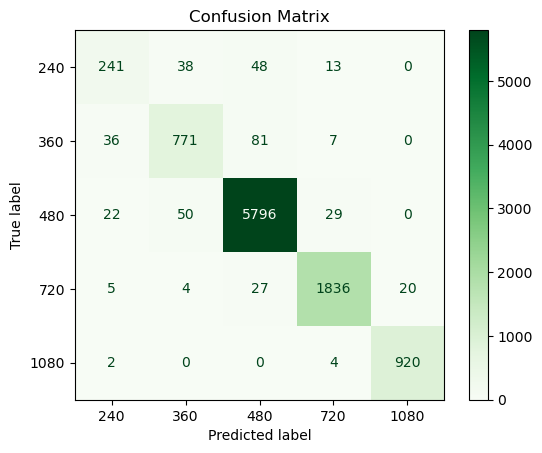

ROC-AUC (OvR): 0.996


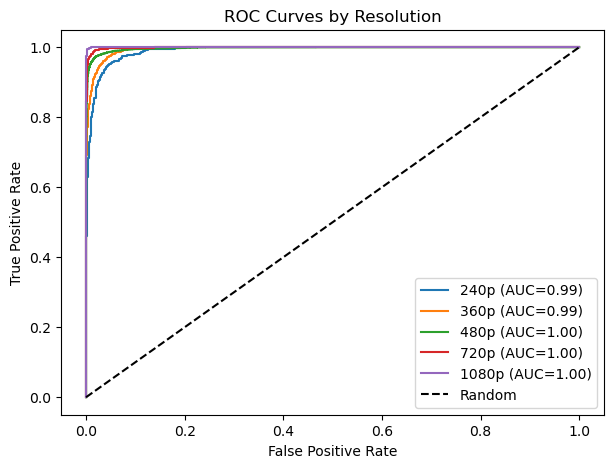

In [118]:
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, auc
)
import matplotlib.pyplot as plt

preds = model.predict(X_test_numeric)
pred_proba = model.predict_proba(X_test_numeric)

# 1. Accuracy
acc = accuracy_score(y_test, preds)
print(f"Accuracy: {acc:.3f}")

# 2. F1 Score
f1 = f1_score(y_test, preds, average="macro")
print(f"F1 Score (macro): {f1:.3f}")

# 3. Confusion Matrix
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm, display_labels=[240, 360, 480, 720, 1080]).plot(cmap="Greens", values_format="d")
plt.title("Confusion Matrix")
plt.show()

# 4. ROC/AUC
auc_score = roc_auc_score(y_test, pred_proba, multi_class="ovr")
print(f"ROC-AUC (OvR): {auc_score:.3f}")

# Plot ROC curves
plt.figure(figsize=(7,5))
class_labels = [240, 360, 480, 720, 1080]
for i, label in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_test == i, pred_proba[:, i])
    plt.plot(fpr, tpr, label=f"{label}p (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Resolution")
plt.legend()
plt.show()

## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

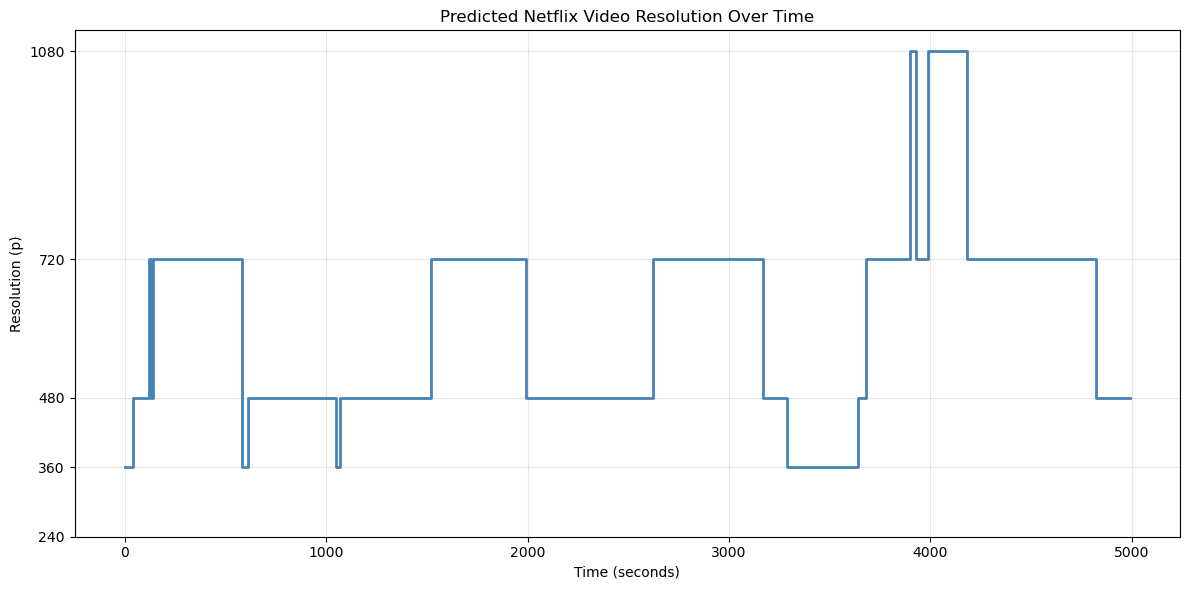

In [130]:
session_features = df_cleaned.select_dtypes(include=[np.number]).copy()
session_features = session_features.drop(columns=["resolution"], errors="ignore")
encoded_predictions = model.predict(session_features)

resolution_map = {0: 240, 1: 360, 2: 480, 3: 720, 4: 1080}
resolution_predictions = np.array([resolution_map[pred] for pred in encoded_predictions])

time_limit = 5000
num_predictions = min(len(resolution_predictions), time_limit // 10)
time_steps = np.arange(0, num_predictions * 10, 10)
resolution_predictions = resolution_predictions[:num_predictions]

plt.figure(figsize=(12, 6))
plt.step(time_steps, resolution_predictions, where='post', linewidth=2, color="steelblue")
plt.xlabel("Time (seconds)")
plt.ylabel("Resolution (p)")
plt.title("Predicted Netflix Video Resolution Over Time")
plt.yticks([240, 360, 480, 720, 1080])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()